## 1. Import the dependencies

In [ ]:
# !pip install torch_fidelity

In [ ]:
!nvidia-smi

Wed Apr  2 00:56:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        On  |   00000000:41:00.0 Off |                  N/A |
| 30%   28C    P8             24W /  350W |       2MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# !kill -9      1196332                                                                               

In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import itertools
import random
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F
import pandas as pd
import torch_fidelity


In [ ]:
SEED = 42
print("Random Seed:", SEED)
random.seed(SEED)
np.random.seed(SEED)
torch_seed = torch.initial_seed()
torch.manual_seed(torch_seed)
print("Torch seed:" , torch_seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cuda = torch.cuda.is_available()
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

Random Seed: 42
Torch seed: 16109772023028774379


## 2. Define your model

In [ ]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(x_cat)
        return self.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(channels, reduction_ratio)
        self.spatial_att = SpatialAttention(kernel_size)
        
    def forward(self, x):
        x = x * self.channel_att(x)
        x = x * self.spatial_att(x)
        return x

class ImprovedResidualBlock(nn.Module):
    def __init__(self, in_features, use_cbam=True):
        super(ImprovedResidualBlock, self).__init__()
        
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, kernel_size=3, padding=0),
            nn.InstanceNorm2d(in_features),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, kernel_size=3, padding=0),
            nn.InstanceNorm2d(in_features)
        )
        
        # Add both SE and CBAM attention
        self.se = SqueezeExcitation(in_features)
        self.use_cbam = use_cbam
        if use_cbam:
            self.cbam = CBAM(in_features)
    
    def forward(self, x):
        out = self.block(x)
        out = self.se(out)  # Apply squeeze-excitation
        if self.use_cbam:
            out = self.cbam(out)  # Apply CBAM
        return x + out  # Skip connection

class SqueezeExcitation(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SqueezeExcitation, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_dim, in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_dim, in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_dim, in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        batch_size, C, width, height = x.size()
        
        # Project to get query, key, value
        query = self.query_conv(x).view(batch_size, -1, width*height).permute(0, 2, 1)
        key = self.key_conv(x).view(batch_size, -1, width*height)
        value = self.value_conv(x).view(batch_size, -1, width*height)
        
        # Calculate attention map
        attention = torch.bmm(query, key)
        attention = self.softmax(attention)
        
        # Apply attention to value
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        
        # Apply gamma parameter and add to input
        out = self.gamma * out + x
        return out

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features_d=64):
        super(Discriminator, self).__init__()
        
        self.scale_factor = 16
        
        # Feature extraction layers - shared between patch and global discriminators
        self.feature_extraction = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(in_channels, features_d, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.utils.spectral_norm(nn.Conv2d(features_d, features_d*2, kernel_size=4, stride=2, padding=1)),
            nn.InstanceNorm2d(features_d*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.utils.spectral_norm(nn.Conv2d(features_d*2, features_d*4, kernel_size=4, stride=2, padding=1)),
            nn.InstanceNorm2d(features_d*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.utils.spectral_norm(nn.Conv2d(features_d*4, features_d*8, kernel_size=4, stride=2, padding=1)),
            nn.InstanceNorm2d(features_d*8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # PatchGAN output
        self.patch_output = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(features_d*8, 1, kernel_size=4, stride=1, padding=1))
        )
        
        # Global discriminator output
        self.global_output = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(features_d*8, 1)
        )
    
    def forward(self, x, get_features=False):
        features = self.feature_extraction(x)
        patch_out = self.patch_output(features)
        global_out = self.global_output(features)
        
        if get_features:
            # Return intermediate features for feature matching loss
            return patch_out, global_out, [features]
        return patch_out, global_out

In [ ]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, num_residual_blocks=9, use_attention=True):
        super(Generator, self).__init__()
        
        # Initial convolution block
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, 64, kernel_size=7, padding=0),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]
        
        # Enhanced downsampling with more filters
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2
        
        # Improved residual blocks with attention
        for i in range(num_residual_blocks):
            # Add CBAM to the middle blocks for global coherence
            use_cbam = (i >= 3 and i <= 6)
            model += [ImprovedResidualBlock(in_features, use_cbam=use_cbam)]
        
        # Add self-attention layer for better global coherence
        if use_attention:
            model += [SelfAttention(in_features)]
        
        # Enhanced upsampling pathway
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2
        
        # Output layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, in_channels, kernel_size=7, padding=0),
            nn.Tanh()
        ]
        
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
def relativistic_loss(real_pred, fake_pred, criterion):
    # Standard GAN uses D(real) and D(fake) independently
    # Relativistic GAN compares real to fake samples
    
    # For patch-level predictions
    real_patch, real_global = real_pred
    fake_patch, fake_global = fake_pred
    
    # Relativistic average for patch outputs
    real_fake_diff_patch = real_patch - fake_patch.mean(0, keepdim=True)
    fake_real_diff_patch = fake_patch - real_patch.mean(0, keepdim=True)
    
    # Relativistic average for global outputs
    real_fake_diff_global = real_global - fake_global.mean(0, keepdim=True)
    fake_real_diff_global = fake_global - real_global.mean(0, keepdim=True)
    
    # Combine losses
    batch_size = real_global.size(0)
    ones = torch.ones(batch_size, 1).cuda() if torch.cuda.is_available() else torch.ones(batch_size, 1)
    zeros = torch.zeros(batch_size, 1).cuda() if torch.cuda.is_available() else torch.zeros(batch_size, 1)
    
    # Patch level loss
    loss_real_patch = criterion(real_fake_diff_patch, torch.ones_like(real_fake_diff_patch))
    loss_fake_patch = criterion(fake_real_diff_patch, torch.zeros_like(fake_real_diff_patch))
    
    # Global level loss
    loss_real_global = nn.BCEWithLogitsLoss()(real_fake_diff_global, ones)
    loss_fake_global = nn.BCEWithLogitsLoss()(fake_real_diff_global, zeros)
    
    # Combine patch and global losses
    loss_real = 0.7 * loss_real_patch + 0.3 * loss_real_global
    loss_fake = 0.7 * loss_fake_patch + 0.3 * loss_fake_global
    
    return (loss_real + loss_fake) / 2

def compute_gradient_penalty(discriminator, real_samples, fake_samples):
    # Random interpolation of real and fake samples
    alpha = torch.rand((real_samples.size(0), 1, 1, 1)).type(Tensor)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    
    # Get discriminator output for interpolated images
    patch_interpolates, global_interpolates = discriminator(interpolates)
    
    # Set fake gradients for patch outputs
    fake_patch_grad = torch.ones_like(patch_interpolates).type(Tensor)
    patch_gradients = torch.autograd.grad(
        outputs=patch_interpolates,
        inputs=interpolates,
        grad_outputs=fake_patch_grad,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    
    # Flatten gradients and compute penalty
    patch_gradients = patch_gradients.reshape(real_samples.size(0), -1)
    patch_gradient_penalty = ((patch_gradients.norm(2, dim=1) - 1) ** 2).mean()
    
    # Set fake gradients for global outputs
    fake_global_grad = torch.ones_like(global_interpolates).type(Tensor)
    global_gradients = torch.autograd.grad(
        outputs=global_interpolates,
        inputs=interpolates,
        grad_outputs=fake_global_grad,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    
    # Flatten gradients and compute penalty
    global_gradients = global_gradients.reshape(real_samples.size(0), -1)
    global_gradient_penalty = ((global_gradients.norm(2, dim=1) - 1) ** 2).mean()
    
    # Combined penalty
    return 0.7 * patch_gradient_penalty + 0.3 * global_gradient_penalty

def feature_matching_loss(real_features, fake_features):
    """
    Calculate feature matching loss by comparing features extracted from real and fake images.
    
    Args:
        real_features: List of feature tensors from real images
        fake_features: List of feature tensors from fake images
        
    Returns:
        The mean absolute difference between real and fake features
    """
    # Initialize loss
    loss = 0.0
    
    # Both should be lists of the same length, containing feature maps
    assert len(real_features) == len(fake_features), "Feature lists must have same length"
    
    # Calculate L1 loss between corresponding feature maps
    for real_feat, fake_feat in zip(real_features, fake_features):
        # Make sure feature maps have same shape
        assert real_feat.shape == fake_feat.shape, f"Feature shapes don't match: {real_feat.shape} vs {fake_feat.shape}"
        # Calculate mean absolute error between feature maps
        loss += torch.mean(torch.abs(real_feat - fake_feat))
    
    # Average over number of feature maps
    return loss / len(real_features)

In [ ]:
class ImagePool:
    def __init__(self, pool_size=50):
        """Initialize the ImagePool with a specified pool size."""
        self.pool_size = pool_size
        self.num_imgs = 0
        self.images = []

    def query(self, images):
        """
        Returns images from the pool.
        If the pool is not full, add the incoming images.
        Otherwise, randomly choose to return an old image or the current one.
        """
        if self.pool_size == 0:
            return images
        return_images = []
        for image in images:
            image = torch.unsqueeze(image.data, 0)  # add a batch dimension if needed
            if self.num_imgs < self.pool_size:
                self.images.append(image)
                self.num_imgs += 1
                return_images.append(image)
            else:
                # With probability 0.5, use a previously stored image
                if random.uniform(0, 1) > 0.5:
                    idx = random.randint(0, self.pool_size - 1)
                    tmp = self.images[idx].clone()
                    self.images[idx] = image
                    return_images.append(tmp)
                else:
                    return_images.append(image)
        return torch.cat(return_images, 0)

In [ ]:
def print_epoch_losses(epoch, gen_losses, gen_AB_losses, gen_BA_losses, id_losses, gan_losses, cycle_losses, fm_losses, discA_losses, discB_losses):
    # Calculate average losses for the epoch
    avg_gen_loss = sum(gen_losses) / len(gen_losses)
    avg_gen_AB_loss = sum(gen_AB_losses) / len(gen_AB_losses)
    avg_gen_BA_loss = sum(gen_BA_losses) / len(gen_BA_losses)
    avg_id_loss = sum(id_losses) / len(id_losses)
    avg_gan_loss = sum(gan_losses) / len(gan_losses)
    avg_cycle_loss = sum(cycle_losses) / len(cycle_losses)
    avg_fm_loss = sum(fm_losses) / len(fm_losses)
    avg_discA_loss = sum(discA_losses) / len(discA_losses)
    avg_discB_loss = sum(discB_losses) / len(discB_losses)
    
    print(f"Epoch {epoch}:")
    print(f"  Generator Total Loss: {avg_gen_loss:.4f}")
    print(f"    G_AB (A->B) Loss:  {avg_gen_AB_loss:.4f}")
    print(f"    G_BA (B->A) Loss:  {avg_gen_BA_loss:.4f}")
    print(f"    Identity Loss:     {avg_id_loss:.4f}")
    print(f"    GAN Loss:          {avg_gan_loss:.4f}")
    print(f"    Cycle Loss:        {avg_cycle_loss:.4f}")
    print(f"    Feature Match:     {avg_fm_loss:.4f}")
    print(f"  Discriminator A Loss: {avg_discA_loss:.4f}")
    print(f"  Discriminator B Loss: {avg_discB_loss:.4f}")

def plot_losses(gen_loss_history, gen_AB_loss_history, gen_BA_loss_history, 
                id_loss_history, gan_loss_history, cycle_loss_history, fm_loss_history,
                discA_loss_history, discB_loss_history):
    epochs = range(1, len(gen_loss_history) + 1)
    
    plt.figure(figsize=(15, 10))
    
    # Plot Generator Losses
    plt.subplot(2, 2, 1)
    plt.plot(epochs, gen_loss_history, label="Total Generator Loss", color="blue")
    plt.plot(epochs, gen_AB_loss_history, label="G_AB Loss", color="cyan", linestyle="dashed")
    plt.plot(epochs, gen_BA_loss_history, label="G_BA Loss", color="magenta", linestyle="dashed")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Generator Total Losses")
    plt.legend()
    plt.grid()
    
    # Plot Component Losses
    plt.subplot(2, 2, 2)
    plt.plot(epochs, id_loss_history, label="Identity Loss", color="green")
    plt.plot(epochs, gan_loss_history, label="GAN Loss", color="red")
    plt.plot(epochs, cycle_loss_history, label="Cycle Loss", color="orange")
    plt.plot(epochs, fm_loss_history, label="Feature Match Loss", color="purple")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Components")
    plt.legend()
    plt.grid()
    
    # Plot Discriminator Losses
    plt.subplot(2, 2, 3)
    plt.plot(epochs, discA_loss_history, label="Discriminator A Loss", color="teal")
    plt.plot(epochs, discB_loss_history, label="Discriminator B Loss", color="brown")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Discriminator Losses")
    plt.legend()
    plt.grid()
    
    # Plot combined important losses for overall view
    plt.subplot(2, 2, 4)
    plt.plot(epochs, gen_loss_history, label="Generator Loss", color="blue")
    plt.plot(epochs, cycle_loss_history, label="Cycle Loss", color="orange")
    plt.plot(epochs, gan_loss_history, label="GAN Loss", color="red")
    plt.plot(epochs, [(a+b)/2 for a, b in zip(discA_loss_history, discB_loss_history)], 
             label="Avg Discriminator Loss", color="purple")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Key Losses")
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()

def show_images(real_A, fake_B, recov_A, real_B, fake_A, recov_B, size=(256, 256), num_samples=5):
    """Display three rows of images: real A, fake B, reconstructed A, real B, fake A, reconstructed B"""
    # Denormalize images from [-1, 1] to [0, 1]
    def denorm(tensor):
        return (tensor * 0.5 + 0.5).clamp(0, 1)
    
    # Create a figure with 3 rows of images
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Only use a subset of images
    real_A = denorm(real_A[:num_samples])
    fake_B = denorm(fake_B[:num_samples])
    recov_A = denorm(recov_A[:num_samples])
    real_B = denorm(real_B[:num_samples])
    fake_A = denorm(fake_A[:num_samples])
    recov_B = denorm(recov_B[:num_samples])
    
    # Create grids from batches of images
    real_A_grid = make_grid(real_A, nrow=num_samples).permute(1, 2, 0).cpu().numpy()
    fake_B_grid = make_grid(fake_B, nrow=num_samples).permute(1, 2, 0).cpu().numpy()
    recov_A_grid = make_grid(recov_A, nrow=num_samples).permute(1, 2, 0).cpu().numpy()
    real_B_grid = make_grid(real_B, nrow=num_samples).permute(1, 2, 0).cpu().numpy()
    fake_A_grid = make_grid(fake_A, nrow=num_samples).permute(1, 2, 0).cpu().numpy()
    recov_B_grid = make_grid(recov_B, nrow=num_samples).permute(1, 2, 0).cpu().numpy()
    
    # Display the images
    axes[0, 0].imshow(real_A_grid)
    axes[0, 0].set_title("Real A (Domain A)")
    axes[0, 0].axis("off")
    
    axes[0, 1].imshow(fake_B_grid)
    axes[0, 1].set_title("Fake B (Generated from A)")
    axes[0, 1].axis("off")
    
    axes[0, 2].imshow(recov_A_grid)
    axes[0, 2].set_title("Reconstructed A")
    axes[0, 2].axis("off")
    
    axes[1, 0].imshow(real_B_grid)
    axes[1, 0].set_title("Real B (Domain B)")
    axes[1, 0].axis("off")
    
    axes[1, 1].imshow(fake_A_grid)
    axes[1, 1].set_title("Fake A (Generated from B)")
    axes[1, 1].axis("off")
    
    axes[1, 2].imshow(recov_B_grid)
    axes[1, 2].set_title("Reconstructed B")
    axes[1, 2].axis("off")
    
    plt.tight_layout()
    plt.show()

In [ ]:
image_size = (256, 256)
batch_size = 5
n_epochs = 100
lr = 2e-4
betas = (0.5, 0.999)
lambda_cyc = 10.0
lambda_identity = 5.0
lambda_gan = 1.0
lambda_fm = 5.0
lambda_gp = 10.0
pool_size_A = 50
pool_size_B = 50
num_residual_blocks = 9
use_attention = True
features_d = 64
file_name = "EnhancedCycleGAN-256x256"

In [ ]:

"""
Step 3. Define Loss
"""
criterion_GAN = nn.MSELoss()  # For adversarial loss
criterion_cycle = nn.L1Loss()  # For cycle consistency loss
criterion_identity = nn.L1Loss()  # For identity loss

"""
Step 4. Initalize G and D¶
"""
G_AB = Generator(in_channels=3, num_residual_blocks=num_residual_blocks, use_attention=True)
G_BA = Generator(in_channels=3, num_residual_blocks=num_residual_blocks, use_attention=True)
D_A = Discriminator(in_channels=3, features_d=features_d)
D_B = Discriminator(in_channels=3, features_d=features_d)

## Total parameters in CycleGAN should be less than 60MB
total_params = sum(p.numel() for p in G_AB.parameters()) + \
               sum(p.numel() for p in G_BA.parameters()) + \
               sum(p.numel() for p in D_A.parameters()) + \
               sum(p.numel() for p in D_B.parameters())


"""
# modification of parameters computation is forbidden
"""
total_params_million = total_params / (1024 * 1024)
print(f'Total parameters in CycleGAN model: {total_params_million:.2f} million')

cuda = torch.cuda.is_available()
print(f'cuda: {cuda}')
if cuda:
    G_AB = G_AB.cuda()
    D_B = D_B.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()

criterion_GAN = criterion_GAN.cuda()
criterion_cycle = criterion_cycle.cuda()
criterion_identity = criterion_identity.cuda()

"""
Step 5. Configure Optimizers
"""

# Optimizers
optimizer_G = torch.optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), 
                               lr=lr, betas=betas)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=betas)
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=betas)

# Learning rate schedulers
lr_scheduler_G = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_G, T_0=10, T_mult=2, eta_min=1e-5
)
lr_scheduler_D_A = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_D_A, T_0=10, T_mult=2, eta_min=1e-5
)
lr_scheduler_D_B = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_D_B, T_0=10, T_mult=2, eta_min=1e-5
)

# Image pools
fake_A_pool = ImagePool(pool_size=pool_size_A)
fake_B_pool = ImagePool(pool_size=pool_size_B)

Total parameters in CycleGAN model: 27.34 million
cuda: True


In [ ]:
# -------------------------
# Save Model
# -------------------------
def save_checkpoint(model, model_name, torch_seed, checkpoint_dir='models'):
    # Ensure the directory exists
    os.makedirs(checkpoint_dir, exist_ok=True)

    checkpoint = {
        'model': model.state_dict(),
        'torch_seed': torch_seed
    }

    filename = os.path.join(checkpoint_dir, f"{file_name}-{model_name}-best.pth")

    # Save the checkpoint
    torch.save(checkpoint, filename)
    print(f"Model saved to {filename}")

## 3. Load the data

In [ ]:
"""
Step 6. DataLoader
"""
class ImageDataset(Dataset):
    def __init__(self, data_dir, mode='train', transforms=None, split_ratio=0.99):
        A_dir = os.path.join(data_dir, 'VAE_generation/train') # modification forbidden
        B_dir = os.path.join(data_dir, 'VAE_generation_Cartoon/train')  # modification forbidden

        files_A = sorted(os.listdir(A_dir))
        files_B = sorted(os.listdir(B_dir))

        split_idx_A = int(len(files_A) * split_ratio)
        split_idx_B = int(len(files_B) * split_ratio)

        if mode == 'train':
            self.files_A = [os.path.join(A_dir, name) for name in files_A[:split_idx_A]]
            self.files_B = [os.path.join(B_dir, name) for name in files_B[:split_idx_B]]
        elif mode == 'valid':
            self.files_A = [os.path.join(A_dir, name) for name in files_A[split_idx_A:]]
            self.files_B = [os.path.join(B_dir, name) for name in files_B[split_idx_B:]]

        self.transforms = transforms

    def __len__(self):
        return len(self.files_A)

    def __getitem__(self, index):
        file_A = self.files_A[index]
        file_B = self.files_B[index]

        img_A = Image.open(file_A)
        img_B = Image.open(file_B)

        if self.transforms is not None:
            img_A = self.transforms(img_A)
            img_B = self.transforms(img_B)

        return img_A, img_B

data_dir = './image_image_translation'
# data_dir = '/kaggle/input/group-project/image_image_translation'

image_size = (256, 256)
data_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainloader = DataLoader(
    ImageDataset(data_dir, mode='train', transforms=data_transforms),
    batch_size = batch_size,
    shuffle = True,
    num_workers = 3
)

validloader = DataLoader(
    ImageDataset(data_dir, mode='valid', transforms=data_transforms),
    batch_size = batch_size,
    shuffle = False,
    num_workers = 3
)

In [ ]:
# Initialize loss tracking lists
gen_loss_history = []
gen_AB_loss_history = []
gen_BA_loss_history = []
id_loss_history = []
gan_loss_history = []
cycle_loss_history = []
fm_loss_history = []
discA_loss_history = []
discB_loss_history = []

## 4. Train your **model**

Epoch 1:
  Generator Total Loss: 8.5007
    G_AB (A->B) Loss:  4.0529
    G_BA (B->A) Loss:  4.4479
    Identity Loss:     0.1724
    GAN Loss:          0.9222
    Cycle Loss:        0.1944
    Feature Match:     0.1044
  Discriminator A Loss: 17.1793
  Discriminator B Loss: 18.5503


Epoch 2:
  Generator Total Loss: 7.3680
    G_AB (A->B) Loss:  3.4776
    G_BA (B->A) Loss:  3.8904
    Identity Loss:     0.1361
    GAN Loss:          0.9301
    Cycle Loss:        0.1527
    Feature Match:     0.1092
  Discriminator A Loss: 3.2930
  Discriminator B Loss: 3.0466


Epoch 3:
  Generator Total Loss: 7.0002
    G_AB (A->B) Loss:  3.3212
    G_BA (B->A) Loss:  3.6790
    Identity Loss:     0.1233
    GAN Loss:          0.9445
    Cycle Loss:        0.1377
    Feature Match:     0.1124
  Discriminator A Loss: 2.9648
  Discriminator B Loss: 3.4956


Epoch 4:
  Generator Total Loss: 6.9258
    G_AB (A->B) Loss:  3.2704
    G_BA (B->A) Loss:  3.6554
    Identity Loss:     0.1141
    GAN Loss:          0.8770
    Cycle Loss:        0.1266
    Feature Match:     0.1498
  Discriminator A Loss: 2.5009
  Discriminator B Loss: 2.5431


Epoch 5:
  Generator Total Loss: 6.7559
    G_AB (A->B) Loss:  3.1758
    G_BA (B->A) Loss:  3.5801
    Identity Loss:     0.1051
    GAN Loss:          0.8641
    Cycle Loss:        0.1160
    Feature Match:     0.1657
  Discriminator A Loss: 2.3602
  Discriminator B Loss: 2.0584


Epoch 6:
  Generator Total Loss: 6.5391
    G_AB (A->B) Loss:  3.0998
    G_BA (B->A) Loss:  3.4393
    Identity Loss:     0.0983
    GAN Loss:          0.8466
    Cycle Loss:        0.1075
    Feature Match:     0.1713
  Discriminator A Loss: 2.2509
  Discriminator B Loss: 1.9487


Epoch 7:
  Generator Total Loss: 6.2777
    G_AB (A->B) Loss:  3.0822
    G_BA (B->A) Loss:  3.1956
    Identity Loss:     0.0914
    GAN Loss:          0.8598
    Cycle Loss:        0.0981
    Feature Match:     0.1682
  Discriminator A Loss: 1.5619
  Discriminator B Loss: 2.3696


Epoch 8:
  Generator Total Loss: 6.2205
    G_AB (A->B) Loss:  2.9659
    G_BA (B->A) Loss:  3.2546
    Identity Loss:     0.0869
    GAN Loss:          0.8533
    Cycle Loss:        0.0918
    Feature Match:     0.1808
  Discriminator A Loss: 1.3224
  Discriminator B Loss: 1.5441


Epoch 9:
  Generator Total Loss: 6.0519
    G_AB (A->B) Loss:  2.8625
    G_BA (B->A) Loss:  3.1894
    Identity Loss:     0.0832
    GAN Loss:          0.8659
    Cycle Loss:        0.0858
    Feature Match:     0.1771
  Discriminator A Loss: 1.0461
  Discriminator B Loss: 1.1143


Epoch 10:
  Generator Total Loss: 5.8949
    G_AB (A->B) Loss:  2.7588
    G_BA (B->A) Loss:  3.1361
    Identity Loss:     0.0803
    GAN Loss:          0.8718
    Cycle Loss:        0.0814
    Feature Match:     0.1721
  Discriminator A Loss: 0.9078
  Discriminator B Loss: 1.0039


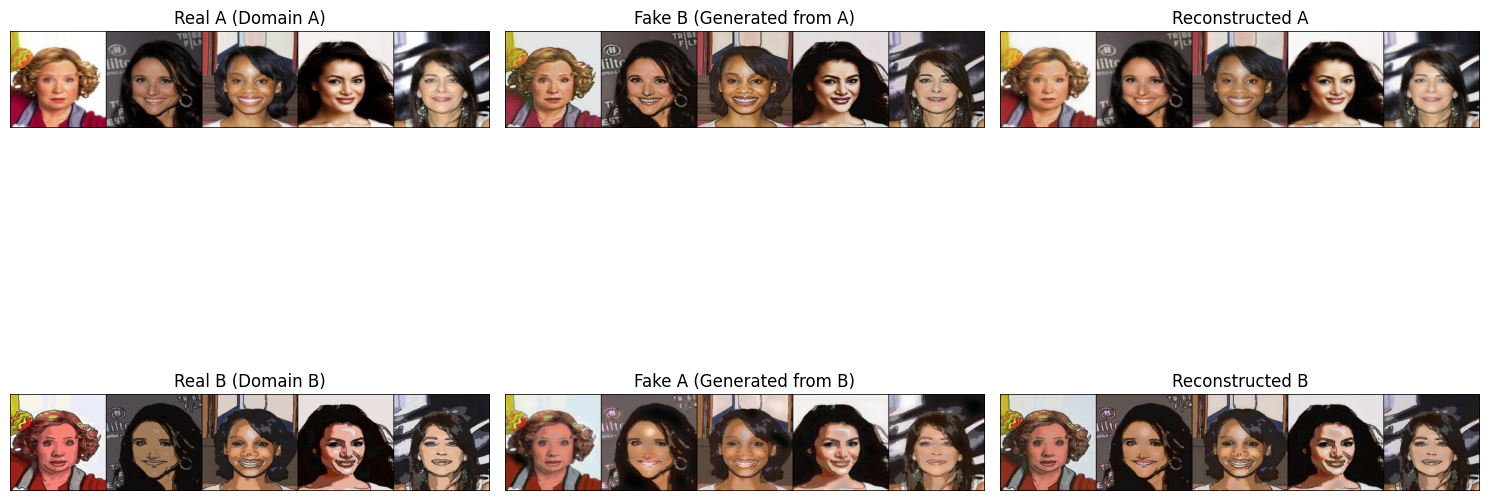

Epoch 11:
  Generator Total Loss: 6.7522
    G_AB (A->B) Loss:  3.3631
    G_BA (B->A) Loss:  3.3890
    Identity Loss:     0.1039
    GAN Loss:          0.9806
    Cycle Loss:        0.1190
    Feature Match:     0.1372
  Discriminator A Loss: 3.1390
  Discriminator B Loss: 3.8958


Epoch 12:
  Generator Total Loss: 6.5721
    G_AB (A->B) Loss:  3.2688
    G_BA (B->A) Loss:  3.3034
    Identity Loss:     0.0976
    GAN Loss:          0.8836
    Cycle Loss:        0.1104
    Feature Match:     0.1621
  Discriminator A Loss: 2.3126
  Discriminator B Loss: 3.1392


Epoch 13:
  Generator Total Loss: 6.4779
    G_AB (A->B) Loss:  3.2211
    G_BA (B->A) Loss:  3.2568
    Identity Loss:     0.0942
    GAN Loss:          0.8680
    Cycle Loss:        0.1062
    Feature Match:     0.1677
  Discriminator A Loss: 1.6319
  Discriminator B Loss: 2.7194


Epoch 14:
  Generator Total Loss: 6.3663
    G_AB (A->B) Loss:  3.0564
    G_BA (B->A) Loss:  3.3099
    Identity Loss:     0.0916
    GAN Loss:          0.8832
    Cycle Loss:        0.1023
    Feature Match:     0.1639
  Discriminator A Loss: 1.1803
  Discriminator B Loss: 2.6687


Epoch 15:
  Generator Total Loss: 6.2789
    G_AB (A->B) Loss:  3.0502
    G_BA (B->A) Loss:  3.2287
    Identity Loss:     0.0884
    GAN Loss:          0.8995
    Cycle Loss:        0.0994
    Feature Match:     0.1608
  Discriminator A Loss: 1.0512
  Discriminator B Loss: 2.6404


Epoch 16:
  Generator Total Loss: 6.1968
    G_AB (A->B) Loss:  2.9814
    G_BA (B->A) Loss:  3.2154
    Identity Loss:     0.0862
    GAN Loss:          0.9037
    Cycle Loss:        0.0965
    Feature Match:     0.1597
  Discriminator A Loss: 0.8233
  Discriminator B Loss: 2.3390


Epoch 17:
  Generator Total Loss: 6.0216
    G_AB (A->B) Loss:  2.9022
    G_BA (B->A) Loss:  3.1194
    Identity Loss:     0.0838
    GAN Loss:          0.8951
    Cycle Loss:        0.0934
    Feature Match:     0.1526
  Discriminator A Loss: 0.7880
  Discriminator B Loss: 1.4448


Epoch 18:
  Generator Total Loss: 5.9542
    G_AB (A->B) Loss:  2.8592
    G_BA (B->A) Loss:  3.0950
    Identity Loss:     0.0814
    GAN Loss:          0.8965
    Cycle Loss:        0.0903
    Feature Match:     0.1541
  Discriminator A Loss: 0.7165
  Discriminator B Loss: 1.2130


Epoch 19:
  Generator Total Loss: 5.9094
    G_AB (A->B) Loss:  2.8518
    G_BA (B->A) Loss:  3.0576
    Identity Loss:     0.0787
    GAN Loss:          0.9134
    Cycle Loss:        0.0870
    Feature Match:     0.1555
  Discriminator A Loss: 0.6518
  Discriminator B Loss: 1.1216


Epoch 20:
  Generator Total Loss: 5.8340
    G_AB (A->B) Loss:  2.8294
    G_BA (B->A) Loss:  3.0047
    Identity Loss:     0.0763
    GAN Loss:          0.9306
    Cycle Loss:        0.0838
    Feature Match:     0.1533
  Discriminator A Loss: 0.7412
  Discriminator B Loss: 0.8257


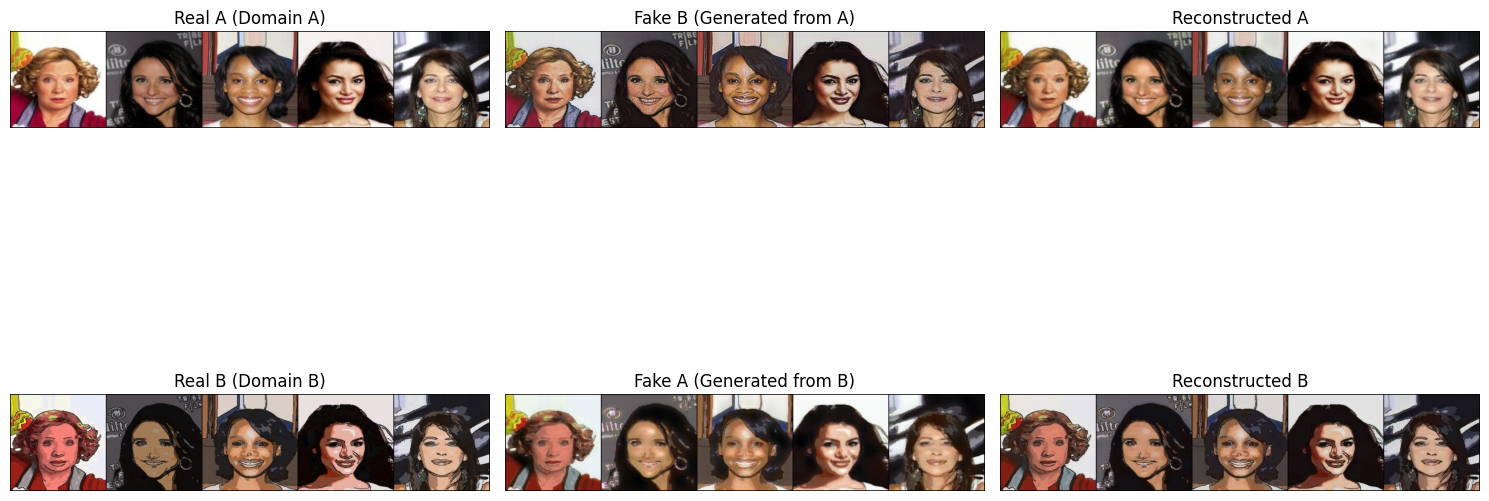

Epoch 21:
  Generator Total Loss: 5.7262
    G_AB (A->B) Loss:  2.7933
    G_BA (B->A) Loss:  2.9329
    Identity Loss:     0.0740
    GAN Loss:          0.9345
    Cycle Loss:        0.0804
    Feature Match:     0.1509
  Discriminator A Loss: 0.6152
  Discriminator B Loss: 0.7536


Epoch 22:
  Generator Total Loss: 5.6871
    G_AB (A->B) Loss:  2.7807
    G_BA (B->A) Loss:  2.9064
    Identity Loss:     0.0716
    GAN Loss:          0.9461
    Cycle Loss:        0.0775
    Feature Match:     0.1528
  Discriminator A Loss: 0.6413
  Discriminator B Loss: 0.7028


Epoch 23:
  Generator Total Loss: 5.5055
    G_AB (A->B) Loss:  2.6982
    G_BA (B->A) Loss:  2.8073
    Identity Loss:     0.0692
    GAN Loss:          0.9366
    Cycle Loss:        0.0742
    Feature Match:     0.1455
  Discriminator A Loss: 0.6182
  Discriminator B Loss: 0.6984


Epoch 24:
  Generator Total Loss: 5.5263
    G_AB (A->B) Loss:  2.7463
    G_BA (B->A) Loss:  2.7800
    Identity Loss:     0.0670
    GAN Loss:          0.9567
    Cycle Loss:        0.0710
    Feature Match:     0.1522
  Discriminator A Loss: 0.5649
  Discriminator B Loss: 0.6354


Epoch 25:
  Generator Total Loss: 5.4722
    G_AB (A->B) Loss:  2.7175
    G_BA (B->A) Loss:  2.7547
    Identity Loss:     0.0651
    GAN Loss:          0.9629
    Cycle Loss:        0.0680
    Feature Match:     0.1536
  Discriminator A Loss: 0.5525
  Discriminator B Loss: 0.6262


Epoch 26:
  Generator Total Loss: 5.4237
    G_AB (A->B) Loss:  2.7078
    G_BA (B->A) Loss:  2.7158
    Identity Loss:     0.0634
    GAN Loss:          0.9711
    Cycle Loss:        0.0652
    Feature Match:     0.1543
  Discriminator A Loss: 0.5420
  Discriminator B Loss: 0.6006


Epoch 27:
  Generator Total Loss: 5.3783
    G_AB (A->B) Loss:  2.6924
    G_BA (B->A) Loss:  2.6858
    Identity Loss:     0.0619
    GAN Loss:          0.9800
    Cycle Loss:        0.0626
    Feature Match:     0.1548
  Discriminator A Loss: 0.5340
  Discriminator B Loss: 0.5866


Epoch 28:
  Generator Total Loss: 5.3298
    G_AB (A->B) Loss:  2.6663
    G_BA (B->A) Loss:  2.6635
    Identity Loss:     0.0606
    GAN Loss:          0.9831
    Cycle Loss:        0.0604
    Feature Match:     0.1549
  Discriminator A Loss: 0.5269
  Discriminator B Loss: 0.5812


Epoch 29:
  Generator Total Loss: 5.2949
    G_AB (A->B) Loss:  2.6501
    G_BA (B->A) Loss:  2.6448
    Identity Loss:     0.0596
    GAN Loss:          0.9881
    Cycle Loss:        0.0586
    Feature Match:     0.1550
  Discriminator A Loss: 0.5207
  Discriminator B Loss: 0.5739


Epoch 30:
  Generator Total Loss: 5.2727
    G_AB (A->B) Loss:  2.6403
    G_BA (B->A) Loss:  2.6323
    Identity Loss:     0.0590
    GAN Loss:          0.9907
    Cycle Loss:        0.0574
    Feature Match:     0.1552
  Discriminator A Loss: 0.5167
  Discriminator B Loss: 0.5680


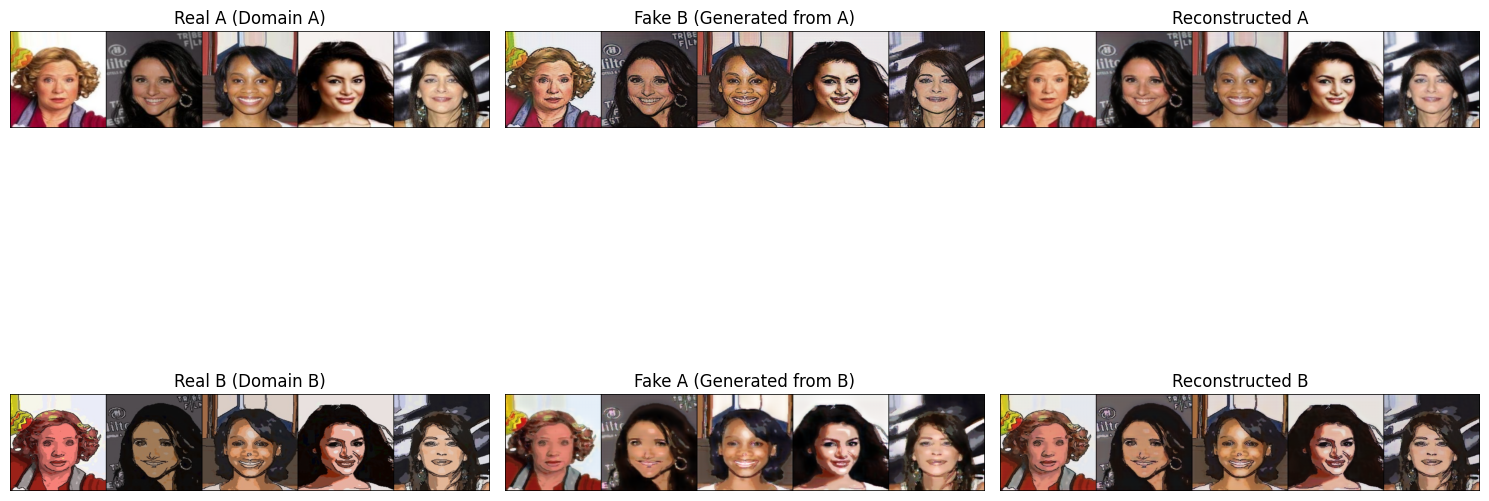

Epoch 31:
  Generator Total Loss: 5.4817
    G_AB (A->B) Loss:  2.6158
    G_BA (B->A) Loss:  2.8658
    Identity Loss:     0.0790
    GAN Loss:          0.8880
    Cycle Loss:        0.0915
    Feature Match:     0.1086
  Discriminator A Loss: 2.3958
  Discriminator B Loss: 2.3305


Epoch 32:
  Generator Total Loss: 5.0678
    G_AB (A->B) Loss:  2.4475
    G_BA (B->A) Loss:  2.6203
    Identity Loss:     0.0753
    GAN Loss:          0.8432
    Cycle Loss:        0.0858
    Feature Match:     0.0912
  Discriminator A Loss: 1.2121
  Discriminator B Loss: 1.4239


Epoch 33:
  Generator Total Loss: 4.9930
    G_AB (A->B) Loss:  2.3960
    G_BA (B->A) Loss:  2.5969
    Identity Loss:     0.0746
    GAN Loss:          0.8502
    Cycle Loss:        0.0846
    Feature Match:     0.0856
  Discriminator A Loss: 0.8666
  Discriminator B Loss: 1.5672


Epoch 34:
  Generator Total Loss: 4.8483
    G_AB (A->B) Loss:  2.3348
    G_BA (B->A) Loss:  2.5136
    Identity Loss:     0.0732
    GAN Loss:          0.8522
    Cycle Loss:        0.0830
    Feature Match:     0.0752
  Discriminator A Loss: 0.9060
  Discriminator B Loss: 0.9579


Epoch 35:
  Generator Total Loss: 4.9179
    G_AB (A->B) Loss:  2.3718
    G_BA (B->A) Loss:  2.5461
    Identity Loss:     0.0733
    GAN Loss:          0.8771
    Cycle Loss:        0.0834
    Feature Match:     0.0763
  Discriminator A Loss: 0.8516
  Discriminator B Loss: 0.8557


Epoch 36:
  Generator Total Loss: 4.9712
    G_AB (A->B) Loss:  2.4270
    G_BA (B->A) Loss:  2.5442
    Identity Loss:     0.0723
    GAN Loss:          0.8975
    Cycle Loss:        0.0832
    Feature Match:     0.0789
  Discriminator A Loss: 0.7460
  Discriminator B Loss: 0.6375


Epoch 37:
  Generator Total Loss: 5.0295
    G_AB (A->B) Loss:  2.4650
    G_BA (B->A) Loss:  2.5645
    Identity Loss:     0.0713
    GAN Loss:          0.9261
    Cycle Loss:        0.0820
    Feature Match:     0.0825
  Discriminator A Loss: 0.6230
  Discriminator B Loss: 0.5687


Epoch 38:
  Generator Total Loss: 5.0295
    G_AB (A->B) Loss:  2.4481
    G_BA (B->A) Loss:  2.5814
    Identity Loss:     0.0701
    GAN Loss:          0.9337
    Cycle Loss:        0.0806
    Feature Match:     0.0849
  Discriminator A Loss: 0.6062
  Discriminator B Loss: 0.6671


Epoch 39:
  Generator Total Loss: 5.0946
    G_AB (A->B) Loss:  2.4904
    G_BA (B->A) Loss:  2.6042
    Identity Loss:     0.0697
    GAN Loss:          0.9589
    Cycle Loss:        0.0806
    Feature Match:     0.0867
  Discriminator A Loss: 0.5548
  Discriminator B Loss: 0.5445


Epoch 40:
  Generator Total Loss: 5.0629
    G_AB (A->B) Loss:  2.4832
    G_BA (B->A) Loss:  2.5797
    Identity Loss:     0.0687
    GAN Loss:          0.9689
    Cycle Loss:        0.0792
    Feature Match:     0.0855
  Discriminator A Loss: 0.7223
  Discriminator B Loss: 0.5039


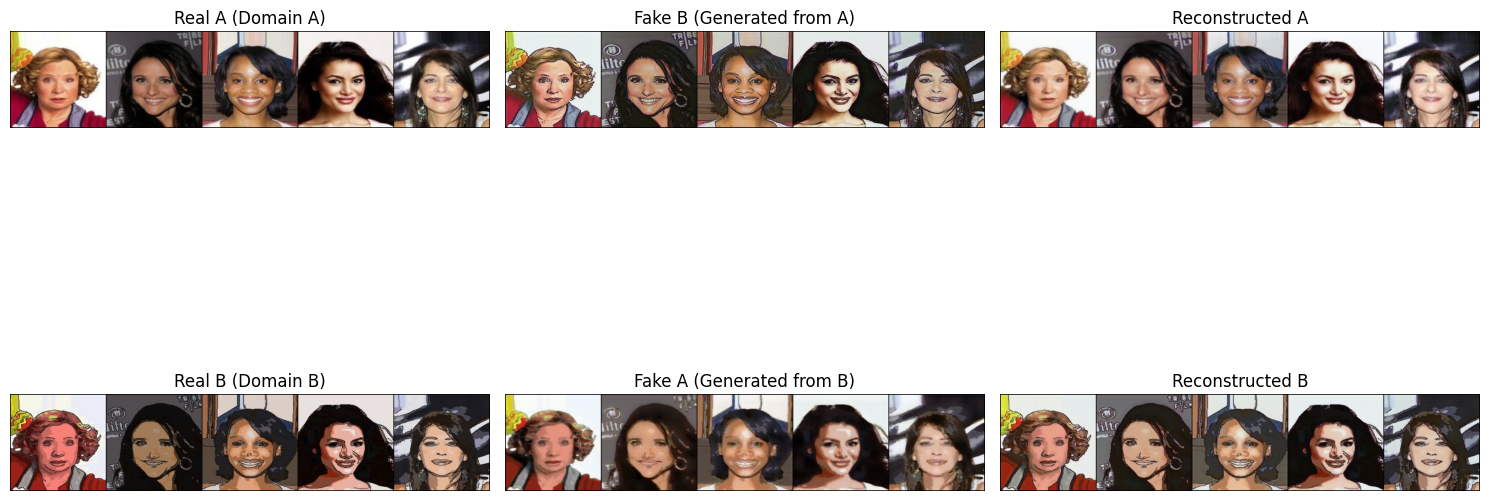

Epoch 41:
  Generator Total Loss: 5.1672
    G_AB (A->B) Loss:  2.5409
    G_BA (B->A) Loss:  2.6263
    Identity Loss:     0.0682
    GAN Loss:          1.0077
    Cycle Loss:        0.0791
    Feature Match:     0.0887
  Discriminator A Loss: 0.5522
  Discriminator B Loss: 0.4855


Epoch 42:
  Generator Total Loss: 5.3188
    G_AB (A->B) Loss:  2.6631
    G_BA (B->A) Loss:  2.6556
    Identity Loss:     0.0674
    GAN Loss:          1.0486
    Cycle Loss:        0.0789
    Feature Match:     0.0970
  Discriminator A Loss: 0.5178
  Discriminator B Loss: 0.4630


Epoch 43:
  Generator Total Loss: 5.0822
    G_AB (A->B) Loss:  2.5309
    G_BA (B->A) Loss:  2.5513
    Identity Loss:     0.0652
    GAN Loss:          1.0033
    Cycle Loss:        0.0749
    Feature Match:     0.0927
  Discriminator A Loss: 0.4985
  Discriminator B Loss: 0.7059


Epoch 44:
  Generator Total Loss: 5.3053
    G_AB (A->B) Loss:  2.6874
    G_BA (B->A) Loss:  2.6179
    Identity Loss:     0.0644
    GAN Loss:          1.0754
    Cycle Loss:        0.0757
    Feature Match:     0.0997
  Discriminator A Loss: 0.4836
  Discriminator B Loss: 0.4620


Epoch 45:
  Generator Total Loss: 5.2556
    G_AB (A->B) Loss:  2.7014
    G_BA (B->A) Loss:  2.5542
    Identity Loss:     0.0631
    GAN Loss:          1.0963
    Cycle Loss:        0.0740
    Feature Match:     0.0952
  Discriminator A Loss: 0.5981
  Discriminator B Loss: 0.4374


Epoch 46:
  Generator Total Loss: 5.0987
    G_AB (A->B) Loss:  2.6474
    G_BA (B->A) Loss:  2.4513
    Identity Loss:     0.0612
    GAN Loss:          1.0916
    Cycle Loss:        0.0716
    Feature Match:     0.0871
  Discriminator A Loss: 0.5713
  Discriminator B Loss: 0.4238


Epoch 47:
  Generator Total Loss: 5.3387
    G_AB (A->B) Loss:  2.7794
    G_BA (B->A) Loss:  2.5593
    Identity Loss:     0.0607
    GAN Loss:          1.1521
    Cycle Loss:        0.0719
    Feature Match:     0.0989
  Discriminator A Loss: 0.4884
  Discriminator B Loss: 0.4171


Epoch 48:
  Generator Total Loss: 5.4039
    G_AB (A->B) Loss:  2.8418
    G_BA (B->A) Loss:  2.5622
    Identity Loss:     0.0595
    GAN Loss:          1.1797
    Cycle Loss:        0.0711
    Feature Match:     0.1027
  Discriminator A Loss: 0.4757
  Discriminator B Loss: 0.4108


Epoch 49:
  Generator Total Loss: 5.4522
    G_AB (A->B) Loss:  2.9101
    G_BA (B->A) Loss:  2.5421
    Identity Loss:     0.0575
    GAN Loss:          1.2231
    Cycle Loss:        0.0692
    Feature Match:     0.1048
  Discriminator A Loss: 0.4729
  Discriminator B Loss: 0.3999


Epoch 50:
  Generator Total Loss: 5.4147
    G_AB (A->B) Loss:  2.8962
    G_BA (B->A) Loss:  2.5184
    Identity Loss:     0.0562
    GAN Loss:          1.2316
    Cycle Loss:        0.0680
    Feature Match:     0.1029
  Discriminator A Loss: 0.4665
  Discriminator B Loss: 0.4210


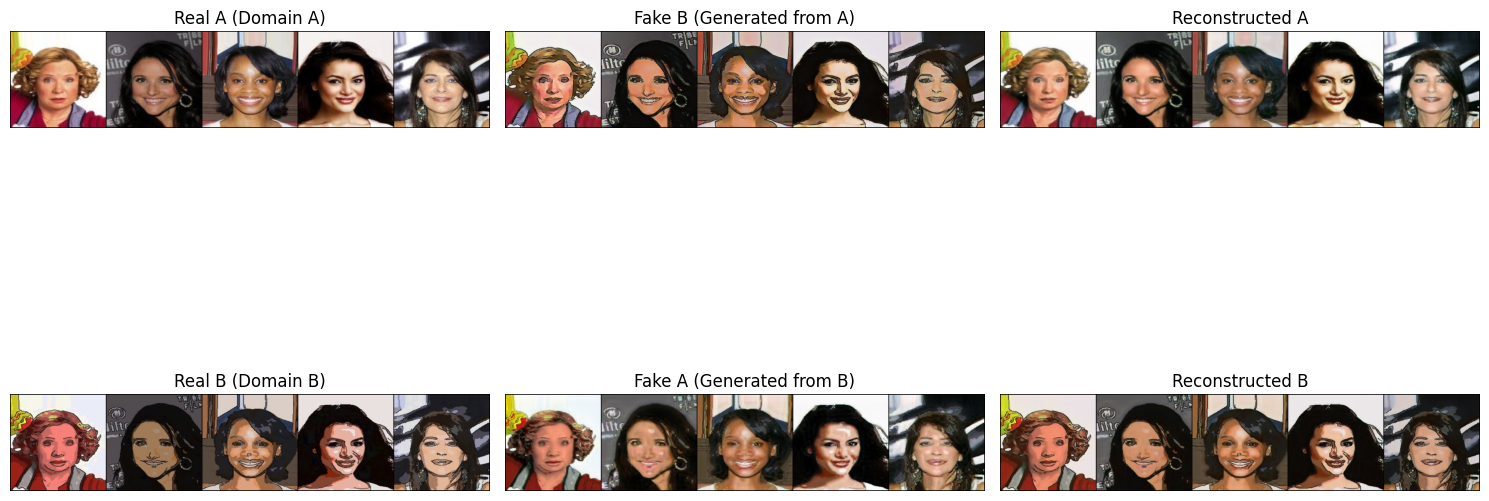

Epoch 51:
  Generator Total Loss: 5.4681
    G_AB (A->B) Loss:  2.9438
    G_BA (B->A) Loss:  2.5243
    Identity Loss:     0.0550
    GAN Loss:          1.2696
    Cycle Loss:        0.0663
    Feature Match:     0.1053
  Discriminator A Loss: 0.4611
  Discriminator B Loss: 0.3912


Epoch 52:
  Generator Total Loss: 5.4701
    G_AB (A->B) Loss:  2.9591
    G_BA (B->A) Loss:  2.5110
    Identity Loss:     0.0533
    GAN Loss:          1.2856
    Cycle Loss:        0.0648
    Feature Match:     0.1069
  Discriminator A Loss: 0.4565
  Discriminator B Loss: 0.3879


Epoch 53:
  Generator Total Loss: 5.4344
    G_AB (A->B) Loss:  2.9604
    G_BA (B->A) Loss:  2.4740
    Identity Loss:     0.0520
    GAN Loss:          1.2988
    Cycle Loss:        0.0632
    Feature Match:     0.1054
  Discriminator A Loss: 0.4791
  Discriminator B Loss: 0.3843


Epoch 54:
  Generator Total Loss: 5.4181
    G_AB (A->B) Loss:  2.9581
    G_BA (B->A) Loss:  2.4600
    Identity Loss:     0.0507
    GAN Loss:          1.3130
    Cycle Loss:        0.0619
    Feature Match:     0.1048
  Discriminator A Loss: 0.4540
  Discriminator B Loss: 0.3811


Epoch 55:
  Generator Total Loss: 5.4050
    G_AB (A->B) Loss:  2.9444
    G_BA (B->A) Loss:  2.4606
    Identity Loss:     0.0490
    GAN Loss:          1.3176
    Cycle Loss:        0.0603
    Feature Match:     0.1074
  Discriminator A Loss: 0.4478
  Discriminator B Loss: 0.3819


Epoch 56:
  Generator Total Loss: 5.3681
    G_AB (A->B) Loss:  2.9241
    G_BA (B->A) Loss:  2.4440
    Identity Loss:     0.0479
    GAN Loss:          1.3140
    Cycle Loss:        0.0589
    Feature Match:     0.1084
  Discriminator A Loss: 0.4452
  Discriminator B Loss: 0.3833


Epoch 57:
  Generator Total Loss: 5.3327
    G_AB (A->B) Loss:  2.9084
    G_BA (B->A) Loss:  2.4243
    Identity Loss:     0.0465
    GAN Loss:          1.3121
    Cycle Loss:        0.0575
    Feature Match:     0.1093
  Discriminator A Loss: 0.4435
  Discriminator B Loss: 0.3822


Epoch 58:
  Generator Total Loss: 5.2971
    G_AB (A->B) Loss:  2.8855
    G_BA (B->A) Loss:  2.4117
    Identity Loss:     0.0455
    GAN Loss:          1.3105
    Cycle Loss:        0.0562
    Feature Match:     0.1097
  Discriminator A Loss: 0.4409
  Discriminator B Loss: 0.3814


Epoch 59:
  Generator Total Loss: 5.2640
    G_AB (A->B) Loss:  2.8713
    G_BA (B->A) Loss:  2.3926
    Identity Loss:     0.0442
    GAN Loss:          1.3133
    Cycle Loss:        0.0546
    Feature Match:     0.1104
  Discriminator A Loss: 0.4391
  Discriminator B Loss: 0.3800


Epoch 60:
  Generator Total Loss: 5.2326
    G_AB (A->B) Loss:  2.8596
    G_BA (B->A) Loss:  2.3730
    Identity Loss:     0.0432
    GAN Loss:          1.3149
    Cycle Loss:        0.0533
    Feature Match:     0.1106
  Discriminator A Loss: 0.4378
  Discriminator B Loss: 0.3812


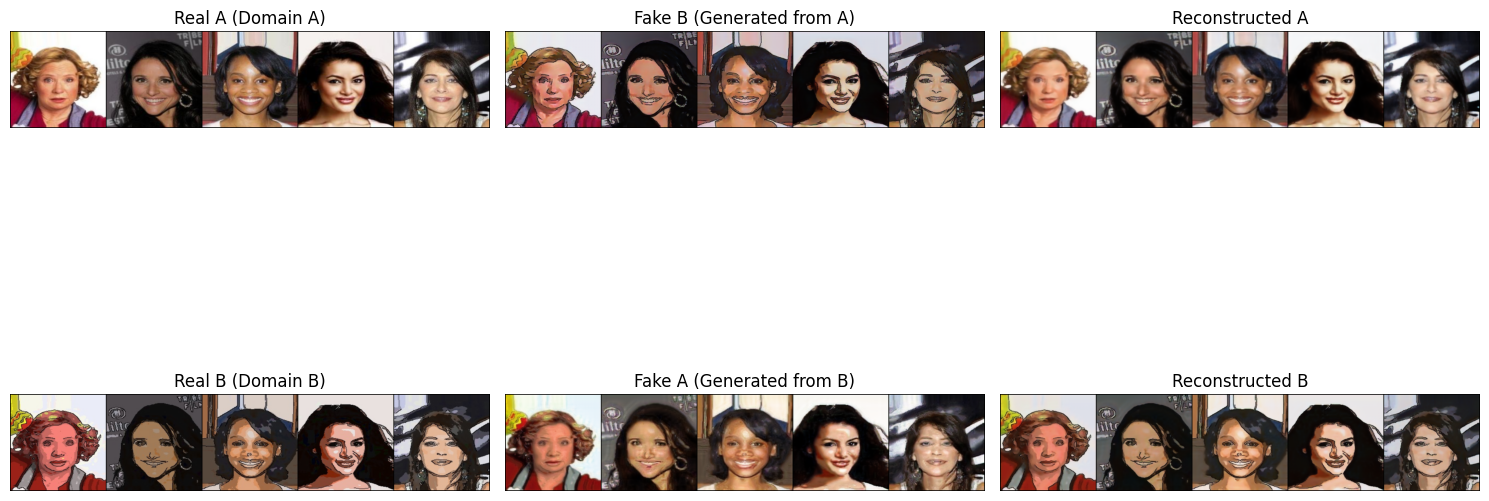

Epoch 61:
  Generator Total Loss: 5.2042
    G_AB (A->B) Loss:  2.8428
    G_BA (B->A) Loss:  2.3614
    Identity Loss:     0.0422
    GAN Loss:          1.3148
    Cycle Loss:        0.0521
    Feature Match:     0.1110
  Discriminator A Loss: 0.4362
  Discriminator B Loss: 0.3806


Epoch 62:
  Generator Total Loss: 5.1894
    G_AB (A->B) Loss:  2.8409
    G_BA (B->A) Loss:  2.3485
    Identity Loss:     0.0413
    GAN Loss:          1.3200
    Cycle Loss:        0.0510
    Feature Match:     0.1117
  Discriminator A Loss: 0.4345
  Discriminator B Loss: 0.3803


Epoch 63:
  Generator Total Loss: 5.1653
    G_AB (A->B) Loss:  2.8281
    G_BA (B->A) Loss:  2.3372
    Identity Loss:     0.0404
    GAN Loss:          1.3207
    Cycle Loss:        0.0500
    Feature Match:     0.1120
  Discriminator A Loss: 0.4334
  Discriminator B Loss: 0.3804


Epoch 64:
  Generator Total Loss: 5.1427
    G_AB (A->B) Loss:  2.8208
    G_BA (B->A) Loss:  2.3218
    Identity Loss:     0.0398
    GAN Loss:          1.3212
    Cycle Loss:        0.0490
    Feature Match:     0.1122
  Discriminator A Loss: 0.4325
  Discriminator B Loss: 0.3803


Epoch 65:
  Generator Total Loss: 5.1232
    G_AB (A->B) Loss:  2.8118
    G_BA (B->A) Loss:  2.3114
    Identity Loss:     0.0392
    GAN Loss:          1.3218
    Cycle Loss:        0.0481
    Feature Match:     0.1125
  Discriminator A Loss: 0.4318
  Discriminator B Loss: 0.3804


Epoch 66:
  Generator Total Loss: 5.1075
    G_AB (A->B) Loss:  2.8032
    G_BA (B->A) Loss:  2.3043
    Identity Loss:     0.0388
    GAN Loss:          1.3213
    Cycle Loss:        0.0476
    Feature Match:     0.1126
  Discriminator A Loss: 0.4307
  Discriminator B Loss: 0.3802


Epoch 67:
  Generator Total Loss: 5.0920
    G_AB (A->B) Loss:  2.7969
    G_BA (B->A) Loss:  2.2951
    Identity Loss:     0.0384
    GAN Loss:          1.3210
    Cycle Loss:        0.0469
    Feature Match:     0.1128
  Discriminator A Loss: 0.4307
  Discriminator B Loss: 0.3800


Epoch 68:
  Generator Total Loss: 5.0815
    G_AB (A->B) Loss:  2.7922
    G_BA (B->A) Loss:  2.2893
    Identity Loss:     0.0380
    GAN Loss:          1.3216
    Cycle Loss:        0.0464
    Feature Match:     0.1130
  Discriminator A Loss: 0.4299
  Discriminator B Loss: 0.3801


Epoch 69:
  Generator Total Loss: 5.0680
    G_AB (A->B) Loss:  2.7845
    G_BA (B->A) Loss:  2.2835
    Identity Loss:     0.0377
    GAN Loss:          1.3190
    Cycle Loss:        0.0460
    Feature Match:     0.1132
  Discriminator A Loss: 0.4300
  Discriminator B Loss: 0.3802


Epoch 70:
  Generator Total Loss: 5.0569
    G_AB (A->B) Loss:  2.7779
    G_BA (B->A) Loss:  2.2790
    Identity Loss:     0.0375
    GAN Loss:          1.3175
    Cycle Loss:        0.0457
    Feature Match:     0.1132
  Discriminator A Loss: 0.4302
  Discriminator B Loss: 0.3804


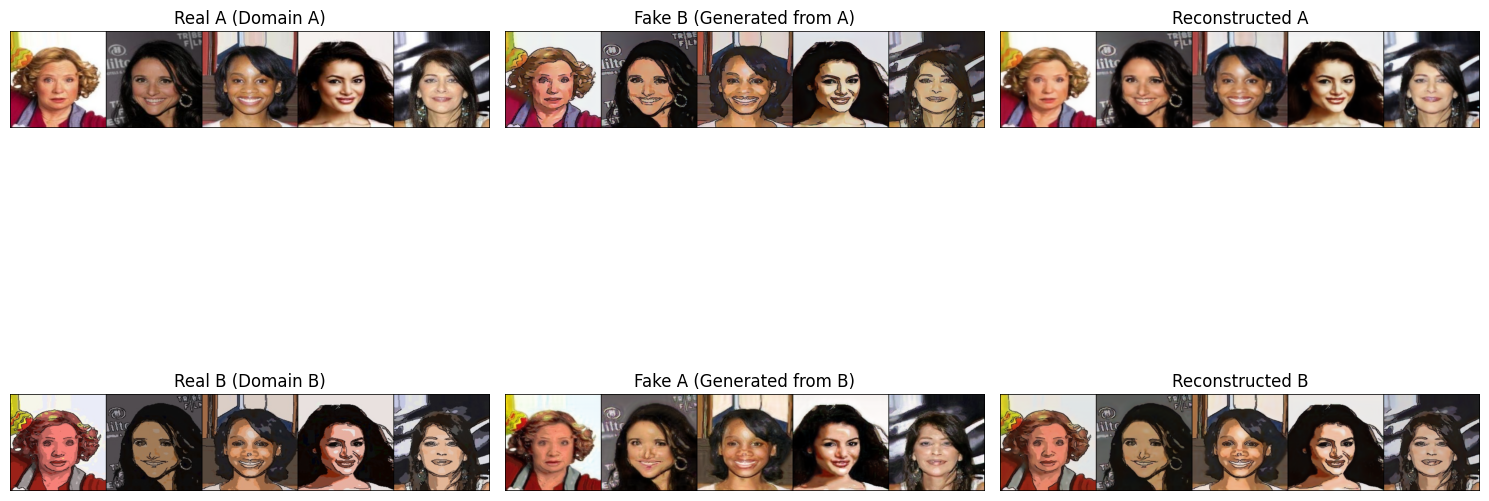

Epoch 71:
  Generator Total Loss: 4.7224
    G_AB (A->B) Loss:  2.2945
    G_BA (B->A) Loss:  2.4280
    Identity Loss:     0.0677
    GAN Loss:          0.8498
    Cycle Loss:        0.0849
    Feature Match:     0.0647
  Discriminator A Loss: 0.8534
  Discriminator B Loss: 1.1457


Epoch 72:
  Generator Total Loss: 4.6465
    G_AB (A->B) Loss:  2.2932
    G_BA (B->A) Loss:  2.3533
    Identity Loss:     0.0595
    GAN Loss:          0.9386
    Cycle Loss:        0.0729
    Feature Match:     0.0716
  Discriminator A Loss: 0.5752
  Discriminator B Loss: 0.5667


Epoch 73:
  Generator Total Loss: 5.0264
    G_AB (A->B) Loss:  2.5773
    G_BA (B->A) Loss:  2.4490
    Identity Loss:     0.0579
    GAN Loss:          1.0672
    Cycle Loss:        0.0730
    Feature Match:     0.0853
  Discriminator A Loss: 0.5104
  Discriminator B Loss: 0.4300


Epoch 74:
  Generator Total Loss: 5.4142
    G_AB (A->B) Loss:  2.8324
    G_BA (B->A) Loss:  2.5818
    Identity Loss:     0.0576
    GAN Loss:          1.1827
    Cycle Loss:        0.0744
    Feature Match:     0.0985
  Discriminator A Loss: 0.4533
  Discriminator B Loss: 0.4025


Epoch 75:
  Generator Total Loss: 5.5727
    G_AB (A->B) Loss:  2.9551
    G_BA (B->A) Loss:  2.6176
    Identity Loss:     0.0570
    GAN Loss:          1.2373
    Cycle Loss:        0.0743
    Feature Match:     0.1042
  Discriminator A Loss: 0.4429
  Discriminator B Loss: 0.3941


Epoch 76:
  Generator Total Loss: 5.5557
    G_AB (A->B) Loss:  2.9520
    G_BA (B->A) Loss:  2.6036
    Identity Loss:     0.0556
    GAN Loss:          1.2489
    Cycle Loss:        0.0725
    Feature Match:     0.1052
  Discriminator A Loss: 0.4448
  Discriminator B Loss: 0.4472


Epoch 77:
  Generator Total Loss: 5.0813
    G_AB (A->B) Loss:  2.5800
    G_BA (B->A) Loss:  2.5013
    Identity Loss:     0.0541
    GAN Loss:          1.0879
    Cycle Loss:        0.0696
    Feature Match:     0.0972
  Discriminator A Loss: 0.4452
  Discriminator B Loss: 0.5425


Epoch 78:
  Generator Total Loss: 5.2049
    G_AB (A->B) Loss:  2.7713
    G_BA (B->A) Loss:  2.4336
    Identity Loss:     0.0543
    GAN Loss:          1.1838
    Cycle Loss:        0.0706
    Feature Match:     0.0881
  Discriminator A Loss: 0.5499
  Discriminator B Loss: 0.3969


Epoch 79:
  Generator Total Loss: 5.4699
    G_AB (A->B) Loss:  2.9048
    G_BA (B->A) Loss:  2.5651
    Identity Loss:     0.0539
    GAN Loss:          1.2549
    Cycle Loss:        0.0708
    Feature Match:     0.1004
  Discriminator A Loss: 0.4439
  Discriminator B Loss: 0.3951


Epoch 80:
  Generator Total Loss: 5.5086
    G_AB (A->B) Loss:  2.9395
    G_BA (B->A) Loss:  2.5691
    Identity Loss:     0.0532
    GAN Loss:          1.2675
    Cycle Loss:        0.0705
    Feature Match:     0.1033
  Discriminator A Loss: 0.4420
  Discriminator B Loss: 0.3904


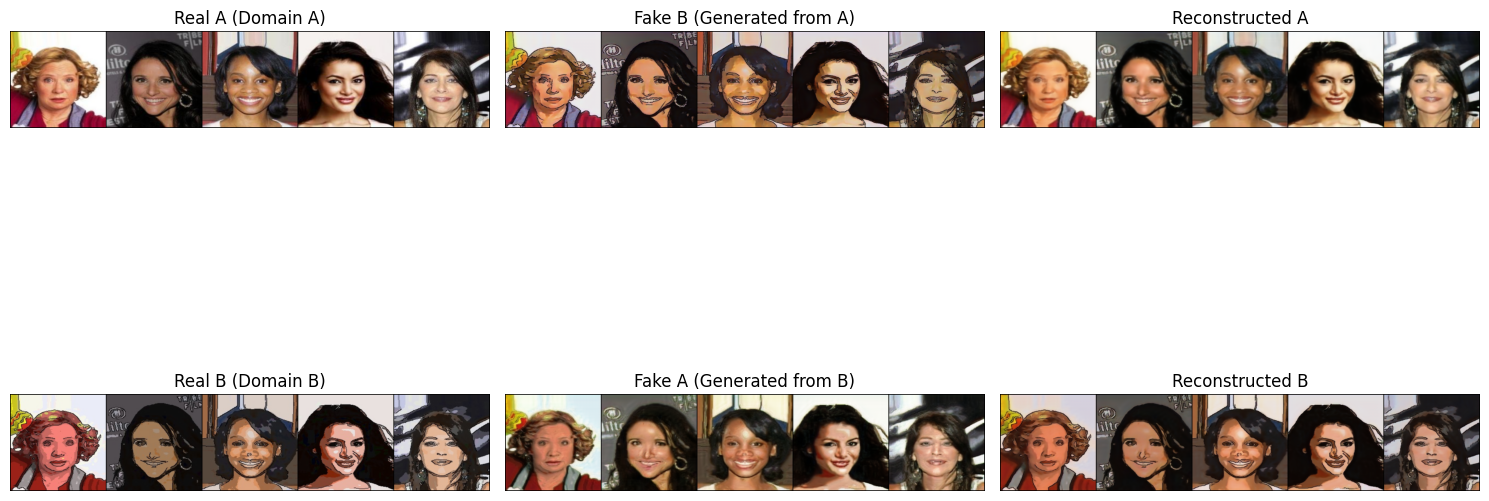

Epoch 81:
  Generator Total Loss: 5.4922
    G_AB (A->B) Loss:  2.9408
    G_BA (B->A) Loss:  2.5515
    Identity Loss:     0.0523
    GAN Loss:          1.2702
    Cycle Loss:        0.0693
    Feature Match:     0.1042
  Discriminator A Loss: 0.4396
  Discriminator B Loss: 0.3909


Epoch 82:
  Generator Total Loss: 5.5154
    G_AB (A->B) Loss:  2.9550
    G_BA (B->A) Loss:  2.5604
    Identity Loss:     0.0521
    GAN Loss:          1.2855
    Cycle Loss:        0.0690
    Feature Match:     0.1044
  Discriminator A Loss: 0.4348
  Discriminator B Loss: 0.3898


Epoch 83:
  Generator Total Loss: 5.4785
    G_AB (A->B) Loss:  2.9435
    G_BA (B->A) Loss:  2.5350
    Identity Loss:     0.0509
    GAN Loss:          1.2891
    Cycle Loss:        0.0675
    Feature Match:     0.1041
  Discriminator A Loss: 0.4354
  Discriminator B Loss: 0.3889


Epoch 84:
  Generator Total Loss: 5.4993
    G_AB (A->B) Loss:  2.9460
    G_BA (B->A) Loss:  2.5533
    Identity Loss:     0.0507
    GAN Loss:          1.2998
    Cycle Loss:        0.0676
    Feature Match:     0.1040
  Discriminator A Loss: 0.4307
  Discriminator B Loss: 0.3871


Epoch 85:
  Generator Total Loss: 4.6715
    G_AB (A->B) Loss:  2.4403
    G_BA (B->A) Loss:  2.2311
    Identity Loss:     0.0492
    GAN Loss:          1.0677
    Cycle Loss:        0.0634
    Feature Match:     0.0777
  Discriminator A Loss: 0.5707
  Discriminator B Loss: 0.5911


Epoch 86:
  Generator Total Loss: 4.9637
    G_AB (A->B) Loss:  2.5683
    G_BA (B->A) Loss:  2.3954
    Identity Loss:     0.0486
    GAN Loss:          1.1476
    Cycle Loss:        0.0641
    Feature Match:     0.0900
  Discriminator A Loss: 0.4353
  Discriminator B Loss: 0.4522


Epoch 87:
  Generator Total Loss: 5.3134
    G_AB (A->B) Loss:  2.8554
    G_BA (B->A) Loss:  2.4580
    Identity Loss:     0.0482
    GAN Loss:          1.2770
    Cycle Loss:        0.0649
    Feature Match:     0.0978
  Discriminator A Loss: 0.4328
  Discriminator B Loss: 0.3896


Epoch 88:
  Generator Total Loss: 5.3238
    G_AB (A->B) Loss:  2.8642
    G_BA (B->A) Loss:  2.4595
    Identity Loss:     0.0474
    GAN Loss:          1.2898
    Cycle Loss:        0.0636
    Feature Match:     0.0998
  Discriminator A Loss: 0.4312
  Discriminator B Loss: 0.3887


Epoch 89:
  Generator Total Loss: 5.3418
    G_AB (A->B) Loss:  2.8750
    G_BA (B->A) Loss:  2.4668
    Identity Loss:     0.0469
    GAN Loss:          1.2959
    Cycle Loss:        0.0635
    Feature Match:     0.1011
  Discriminator A Loss: 0.4290
  Discriminator B Loss: 0.3882


Epoch 90:
  Generator Total Loss: 5.3404
    G_AB (A->B) Loss:  2.8795
    G_BA (B->A) Loss:  2.4610
    Identity Loss:     0.0466
    GAN Loss:          1.3021
    Cycle Loss:        0.0628
    Feature Match:     0.1015
  Discriminator A Loss: 0.4282
  Discriminator B Loss: 0.3866


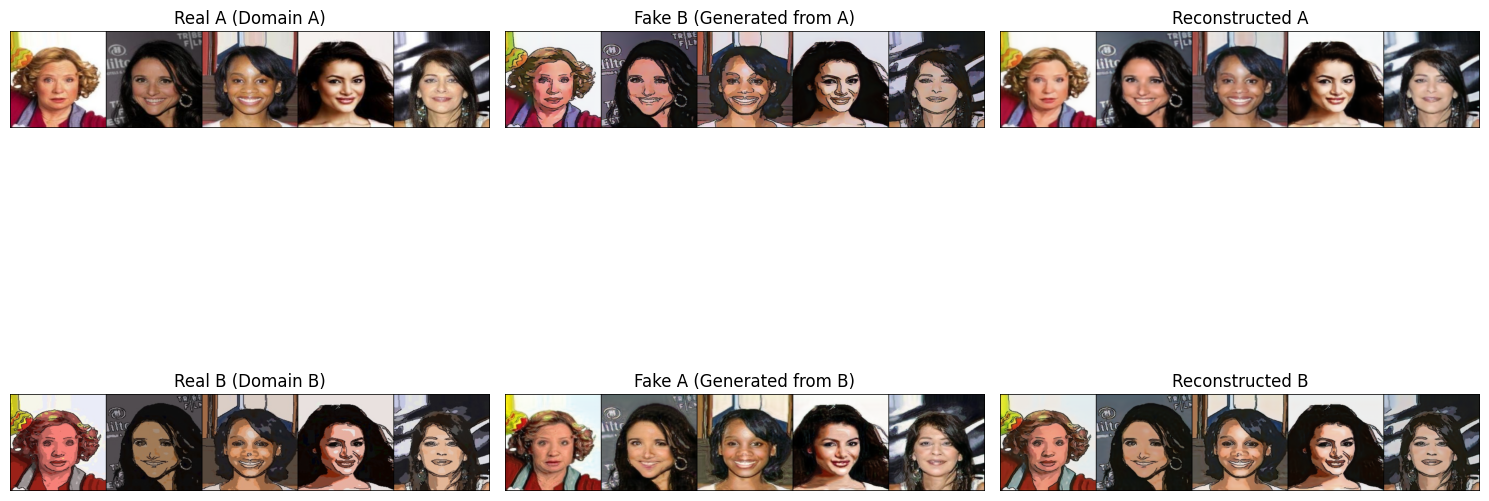

Epoch 91:
  Generator Total Loss: 5.2971
    G_AB (A->B) Loss:  2.8565
    G_BA (B->A) Loss:  2.4405
    Identity Loss:     0.0456
    GAN Loss:          1.2964
    Cycle Loss:        0.0615
    Feature Match:     0.1017
  Discriminator A Loss: 0.4300
  Discriminator B Loss: 0.3873


Epoch 92:
  Generator Total Loss: 5.1398
    G_AB (A->B) Loss:  2.7861
    G_BA (B->A) Loss:  2.3537
    Identity Loss:     0.0448
    GAN Loss:          1.2647
    Cycle Loss:        0.0607
    Feature Match:     0.0949
  Discriminator A Loss: 0.4909
  Discriminator B Loss: 0.3876


Epoch 93:
  Generator Total Loss: 5.1721
    G_AB (A->B) Loss:  2.7914
    G_BA (B->A) Loss:  2.3807
    Identity Loss:     0.0441
    GAN Loss:          1.2846
    Cycle Loss:        0.0597
    Feature Match:     0.0968
  Discriminator A Loss: 0.4346
  Discriminator B Loss: 0.3885


Epoch 94:
  Generator Total Loss: 5.2680
    G_AB (A->B) Loss:  2.8455
    G_BA (B->A) Loss:  2.4226
    Identity Loss:     0.0439
    GAN Loss:          1.3081
    Cycle Loss:        0.0602
    Feature Match:     0.1009
  Discriminator A Loss: 0.4273
  Discriminator B Loss: 0.3861


Epoch 95:
  Generator Total Loss: 5.2669
    G_AB (A->B) Loss:  2.8572
    G_BA (B->A) Loss:  2.4097
    Identity Loss:     0.0432
    GAN Loss:          1.3158
    Cycle Loss:        0.0592
    Feature Match:     0.1018
  Discriminator A Loss: 0.4256
  Discriminator B Loss: 0.3831


Epoch 96:
  Generator Total Loss: 5.2532
    G_AB (A->B) Loss:  2.8541
    G_BA (B->A) Loss:  2.3991
    Identity Loss:     0.0428
    GAN Loss:          1.3145
    Cycle Loss:        0.0587
    Feature Match:     0.1023
  Discriminator A Loss: 0.4275
  Discriminator B Loss: 0.3831


Epoch 97:
  Generator Total Loss: 5.2542
    G_AB (A->B) Loss:  2.8562
    G_BA (B->A) Loss:  2.3980
    Identity Loss:     0.0421
    GAN Loss:          1.3207
    Cycle Loss:        0.0581
    Feature Match:     0.1030
  Discriminator A Loss: 0.4246
  Discriminator B Loss: 0.3831


Epoch 98:
  Generator Total Loss: 5.2318
    G_AB (A->B) Loss:  2.8438
    G_BA (B->A) Loss:  2.3881
    Identity Loss:     0.0415
    GAN Loss:          1.3221
    Cycle Loss:        0.0570
    Feature Match:     0.1032
  Discriminator A Loss: 0.4244
  Discriminator B Loss: 0.3813


Epoch 99:
  Generator Total Loss: 5.2414
    G_AB (A->B) Loss:  2.8492
    G_BA (B->A) Loss:  2.3922
    Identity Loss:     0.0412
    GAN Loss:          1.3292
    Cycle Loss:        0.0567
    Feature Match:     0.1036
  Discriminator A Loss: 0.4221
  Discriminator B Loss: 0.3823


Epoch 100:
  Generator Total Loss: 5.2247
    G_AB (A->B) Loss:  2.8388
    G_BA (B->A) Loss:  2.3859
    Identity Loss:     0.0404
    GAN Loss:          1.3323
    Cycle Loss:        0.0561
    Feature Match:     0.1035
  Discriminator A Loss: 0.4204
  Discriminator B Loss: 0.3796


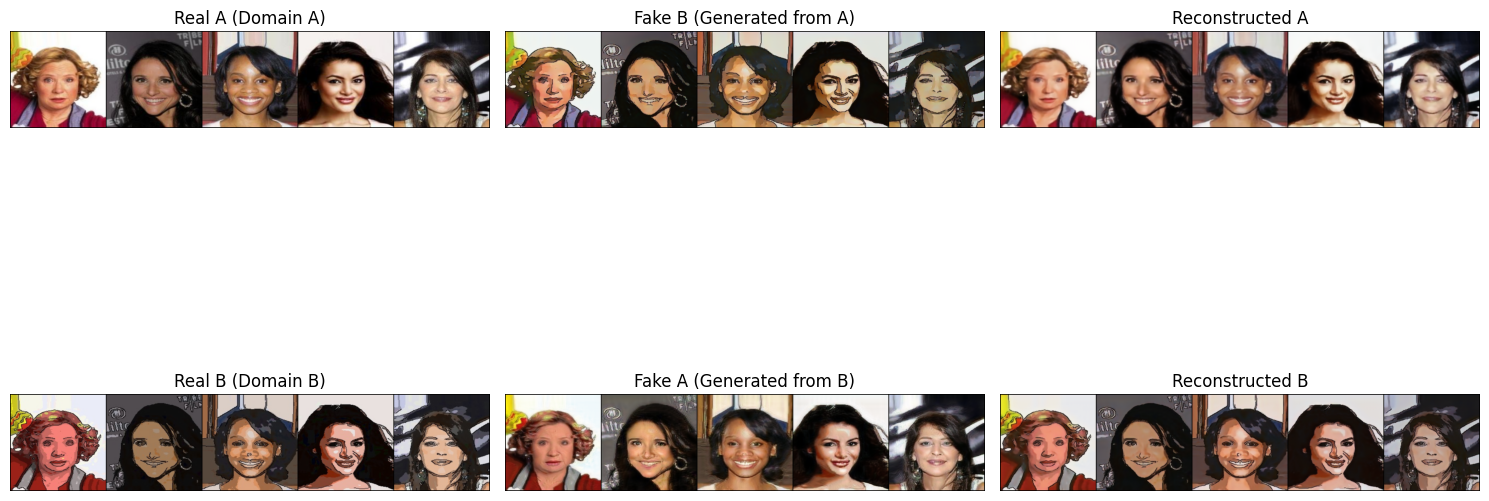

In [ ]:
# Training loop
for epoch in range(n_epochs):
    # Initialize epoch loss tracking
    epoch_gen_losses = []
    epoch_gen_AB_losses = []
    epoch_gen_BA_losses = []
    epoch_id_losses = []
    epoch_gan_losses = []
    epoch_cycle_losses = []
    epoch_fm_losses = []
    epoch_discA_losses = []
    epoch_discB_losses = []
    
    # Iterate through batches
    for i, (real_A, real_B) in enumerate(trainloader):
        real_A, real_B = real_A.type(Tensor), real_B.type(Tensor)
        batch_size = real_A.size(0)
        
        # Set models to training mode
        G_AB.train()
        G_BA.train()
        D_A.train()
        D_B.train()
        
        # Ground truth labels
        valid = torch.ones((batch_size, 1, real_A.size(2) // D_A.scale_factor, 
                          real_A.size(3) // D_A.scale_factor)).type(Tensor)
        fake = torch.zeros((batch_size, 1, real_A.size(2) // D_A.scale_factor, 
                          real_A.size(3) // D_A.scale_factor)).type(Tensor)
        
        # Binary labels for global discriminator
        valid_global = torch.ones(batch_size, 1).type(Tensor)
        fake_global = torch.zeros(batch_size, 1).type(Tensor)
        
        #------------------
        # Train Generators
        #------------------
        optimizer_G.zero_grad()
        
        # Generate fake images
        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)
        
        # Identity loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)
        loss_identity = (loss_id_A + loss_id_B) / 2
        
        # GAN loss with feature extraction for feature matching
        patch_real_A, global_real_A, features_real_A = D_A(real_A, get_features=True)
        patch_fake_A, global_fake_A, features_fake_A = D_A(fake_A, get_features=True)
        patch_real_B, global_real_B, features_real_B = D_B(real_B, get_features=True)
        patch_fake_B, global_fake_B, features_fake_B = D_B(fake_B, get_features=True)
        
        # Relativistic average GAN loss for generators
        loss_GAN_AB = 0.7 * F.mse_loss(patch_fake_B - patch_real_B.mean(0, keepdim=True), 
                                      torch.ones_like(patch_fake_B)) + \
                      0.3 * F.binary_cross_entropy_with_logits(
                          global_fake_B - global_real_B.mean(0, keepdim=True), valid_global)
        
        loss_GAN_BA = 0.7 * F.mse_loss(patch_fake_A - patch_real_A.mean(0, keepdim=True), 
                                      torch.ones_like(patch_fake_A)) + \
                      0.3 * F.binary_cross_entropy_with_logits(
                          global_fake_A - global_real_A.mean(0, keepdim=True), valid_global)
        
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
        
        # Feature matching loss
        loss_FM_A = feature_matching_loss(features_real_A, features_fake_A)
        loss_FM_B = feature_matching_loss(features_real_B, features_fake_B)
        loss_FM = (loss_FM_A + loss_FM_B) / 2 
        
        # Cycle consistency loss
        recov_A = G_BA(fake_B)
        recov_B = G_AB(fake_A)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
        
        # Total generator loss with adaptive weights
        loss_G_AB = lambda_identity * loss_id_A + lambda_gan * loss_GAN_AB + \
                    lambda_cyc * loss_cycle_A + lambda_fm * loss_FM_A
        
        loss_G_BA = lambda_identity * loss_id_B + lambda_gan * loss_GAN_BA + \
                    lambda_cyc * loss_cycle_B + lambda_fm * loss_FM_B
        
        loss_G = loss_G_AB + loss_G_BA
        
        # Backward pass and optimize
        loss_G.backward()
        optimizer_G.step()
        
        #------------------
        # Train Discriminator A
        #------------------
        optimizer_D_A.zero_grad()
        
        # Get real and fake samples (using pool for fake samples)
        fake_A_ = fake_A_pool.query(fake_A.detach())
        
        # Get discriminator outputs
        real_patch_A, real_global_A = D_A(real_A)
        fake_patch_A, fake_global_A = D_A(fake_A_.detach())
        
        # Relativistic loss for discriminator A
        loss_D_A_rel = relativistic_loss(
            (real_patch_A, real_global_A),
            (fake_patch_A, fake_global_A),
            F.mse_loss
        )
        
        # Gradient penalty
        loss_D_A_gp = compute_gradient_penalty(D_A, real_A, fake_A_.detach())
        
        # Total discriminator loss
        loss_D_A = loss_D_A_rel + lambda_gp * loss_D_A_gp
        
        # Backward pass and optimize
        loss_D_A.backward()
        optimizer_D_A.step()
        
        #------------------
        # Train Discriminator B
        #------------------
        optimizer_D_B.zero_grad()
        
        # Get real and fake samples (using pool for fake samples)
        fake_B_ = fake_B_pool.query(fake_B.detach())
        
        # Get discriminator outputs
        real_patch_B, real_global_B = D_B(real_B)
        fake_patch_B, fake_global_B = D_B(fake_B_.detach())
        
        # Relativistic loss for discriminator B
        loss_D_B_rel = relativistic_loss(
            (real_patch_B, real_global_B),
            (fake_patch_B, fake_global_B),
            F.mse_loss
        )
        
        # Gradient penalty
        loss_D_B_gp = compute_gradient_penalty(D_B, real_B, fake_B_.detach())
        
        # Total discriminator loss
        loss_D_B = loss_D_B_rel + lambda_gp * loss_D_B_gp
        
        # Backward pass and optimize
        loss_D_B.backward()
        optimizer_D_B.step()
        
        # Record losses for this batch
        epoch_gen_losses.append(loss_G.item())
        epoch_gen_AB_losses.append(loss_G_AB.item())
        epoch_gen_BA_losses.append(loss_G_BA.item())
        epoch_id_losses.append(loss_identity.item())
        epoch_gan_losses.append(loss_GAN.item())
        epoch_cycle_losses.append(loss_cycle.item())
        epoch_fm_losses.append(loss_FM.item())
        epoch_discA_losses.append(loss_D_A.item())
        epoch_discB_losses.append(loss_D_B.item())
    
    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
    
    # Print epoch statistics
    print_epoch_losses(epoch+1, epoch_gen_losses, epoch_gen_AB_losses, epoch_gen_BA_losses,
                      epoch_id_losses, epoch_gan_losses, epoch_cycle_losses, epoch_fm_losses,
                      epoch_discA_losses, epoch_discB_losses)
    
    # Record the epoch averages in history
    gen_loss_history.append(sum(epoch_gen_losses) / len(epoch_gen_losses))
    gen_AB_loss_history.append(sum(epoch_gen_AB_losses) / len(epoch_gen_AB_losses))
    gen_BA_loss_history.append(sum(epoch_gen_BA_losses) / len(epoch_gen_BA_losses))
    id_loss_history.append(sum(epoch_id_losses) / len(epoch_id_losses))
    gan_loss_history.append(sum(epoch_gan_losses) / len(epoch_gan_losses))
    cycle_loss_history.append(sum(epoch_cycle_losses) / len(epoch_cycle_losses))
    fm_loss_history.append(sum(epoch_fm_losses) / len(epoch_fm_losses))
    discA_loss_history.append(sum(epoch_discA_losses) / len(epoch_discA_losses))
    discB_loss_history.append(sum(epoch_discB_losses) / len(epoch_discB_losses))
    
    # Validation and visualization every 10 epochs
    if (epoch + 1) % 10 == 0:
        # Set models to evaluation mode
        G_AB.eval()
        G_BA.eval()
        
        # Get validation samples
        valid_iter = iter(validloader)
        valid_real_A, valid_real_B = next(valid_iter)
        valid_real_A, valid_real_B = valid_real_A.type(Tensor), valid_real_B.type(Tensor)
        
        # Generate validation results
        with torch.no_grad():
            # Generate fake samples
            valid_fake_B = G_AB(valid_real_A)
            valid_fake_A = G_BA(valid_real_B)
            
            # Generate reconstructed samples
            valid_recov_A = G_BA(valid_fake_B)
            valid_recov_B = G_AB(valid_fake_A)
        
        # Visualize validation results
        show_images(valid_real_A, valid_fake_B, valid_recov_A,
                   valid_real_B, valid_fake_A, valid_recov_B)

    

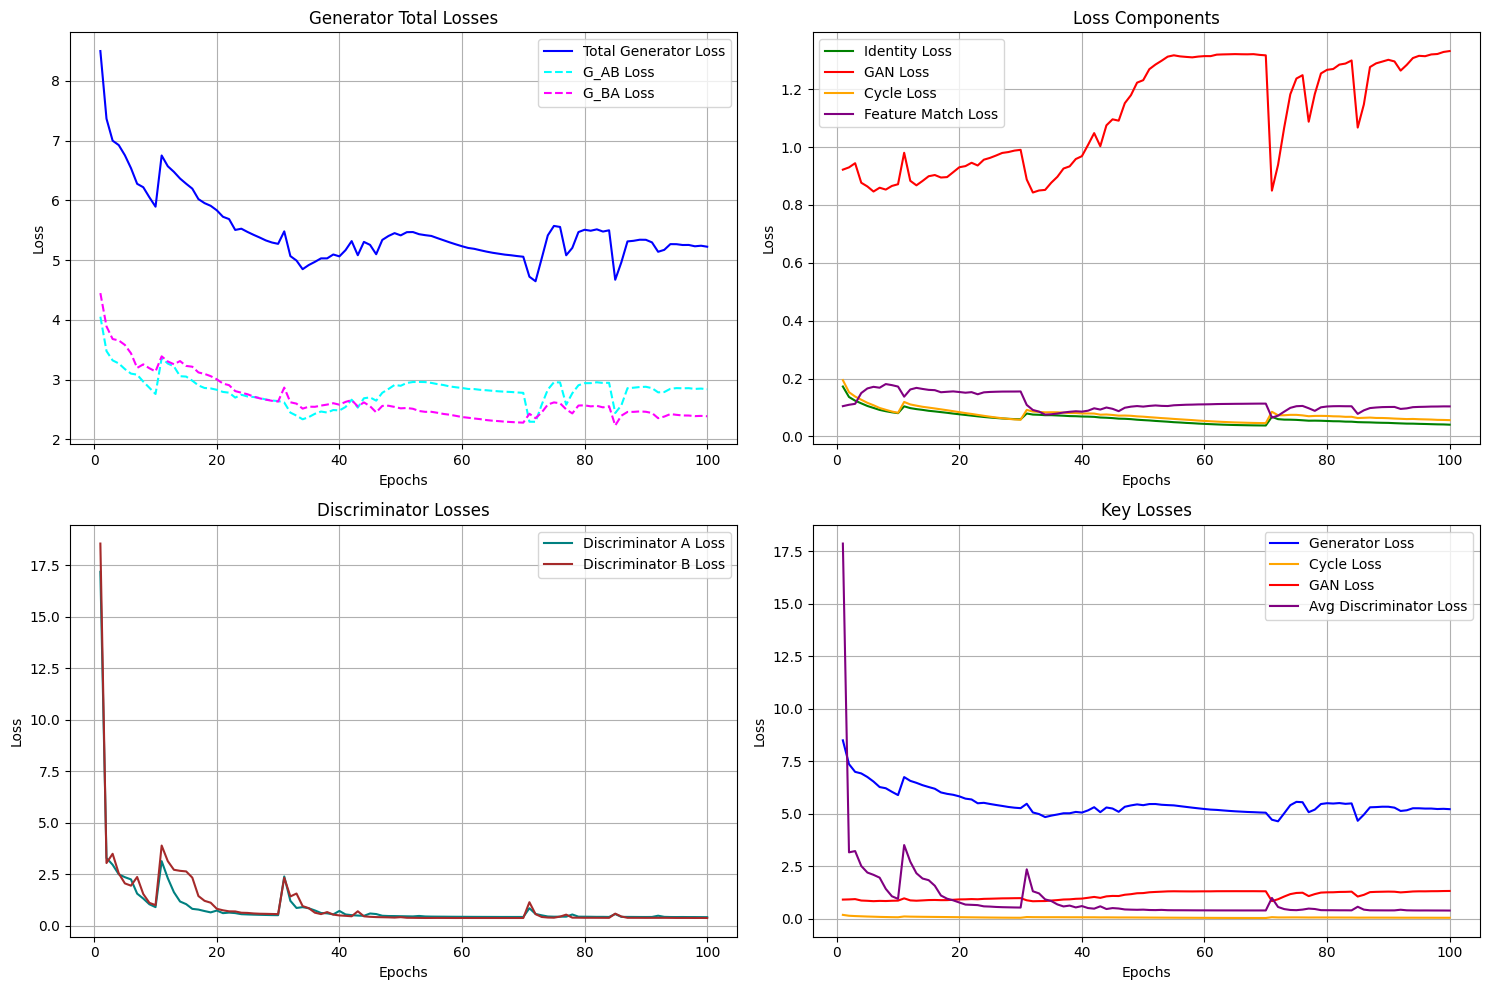

In [ ]:
plot_losses(gen_loss_history, gen_AB_loss_history, gen_BA_loss_history,
           id_loss_history, gan_loss_history, cycle_loss_history, fm_loss_history,
           discA_loss_history, discB_loss_history)

In [ ]:
save_checkpoint(G_AB, "G_AB", torch_seed)
save_checkpoint(G_BA, "G_BA", torch_seed)
save_checkpoint(D_A, "D_A", torch_seed)
save_checkpoint(D_B, "D_B", torch_seed)

Model saved to models/EnhancedCycleGAN-256x256-G_AB-best.pth
Model saved to models/EnhancedCycleGAN-256x256-G_BA-best.pth
Model saved to models/EnhancedCycleGAN-256x256-D_A-best.pth
Model saved to models/EnhancedCycleGAN-256x256-D_B-best.pth


In [ ]:
def load_model(model, model_name):

    # Load the Checkpoing
    checkpoint = torch.load(f"models/{file_name}-{model_name}-best.pth")

    # Load the state dict into the model
    model.load_state_dict(checkpoint['model'])
    torch_seed = checkpoint['torch_seed']

    model.cuda()

    return model, torch_seed

In [ ]:
G_AB, torch_seed = load_model(G_AB, "G_AB")
G_BA, torch_seed = load_model(G_BA, "G_BA")
D_A, torch_seed = load_model(D_A, "D_A")
D_B, torch_seed = load_model(D_B, "D_B")

## 5. Evaluation

In [ ]:
"""
Step 8. Generate Images
"""
## Translation 1: Raw Image --> Cartoon Image
test_dir = os.path.join(data_dir, 'VAE_generation/test') # modification forbidden
files = [os.path.join(test_dir, name) for name in os.listdir(test_dir)]

save_dir = f'./generated_cartoon_images/{file_name}'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

to_image = transforms.ToPILImage()

G_AB.eval()
for i in range(0, len(files), batch_size):
    # read images
    imgs = []
    for j in range(i, min(len(files), i+batch_size)):
        img = Image.open(files[j])
        img = data_transforms(img)
        imgs.append(img)
    imgs = torch.stack(imgs, 0).type(Tensor)

    # generate
    fake_imgs = G_AB(imgs).detach().cpu()

    # save
    for j in range(fake_imgs.size(0)):
        img = fake_imgs[j].squeeze().permute(1, 2, 0)
        img_arr = img.numpy()
        img_arr = (img_arr - np.min(img_arr)) * 255 / (np.max(img_arr) - np.min(img_arr))
        img_arr = img_arr.astype(np.uint8)

        img = to_image(img_arr)
        _, name = os.path.split(files[i+j])
        img.save(os.path.join(save_dir, name))

gt_dir = os.path.join(data_dir, 'VAE_generation_Cartoon/test')
metrics = torch_fidelity.calculate_metrics(
    input1=save_dir,
    input2=gt_dir,
    cuda=True,
    fid=True,
    isc=True
)

fid_score = metrics["frechet_inception_distance"]
is_score = metrics["inception_score_mean"]

if is_score > 0:
    s_value_1 = np.sqrt(fid_score / is_score)
    print("Geometric Mean Score:", s_value_1)
else:
    print("IS is 0, GMS cannot be computed!")

Creating feature extractor "inception-v3-compat" with features ['logits_unbiased', '2048']


Extracting features from input1
Looking for samples non-recursivelty in "./generated_cartoon_images/EnhancedCycleGAN-256x256" with extensions png,jpg,jpeg
Found 1000 samples, some are lossy-compressed - this may affect metrics
/common/home/users/z/zhirong.tan.2022/jupyterlab-venv-pytorch-240/lib/python3.11/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)



Processing samples:   0%|          | 0/1000 [00:00<?, ?samples/s]


Processing samples:   6%|▋         | 64/1000 [00:00<00:08, 111.57samples/s]


Processing samples:  19%|█▉        | 192/1000 [00:00<00:02, 334.46samples/s]


Processing samples:  32%|███▏      | 320/1000 [00:00<00:01, 522.31samples/s]


Processing samples:  45%|████▍     | 448/1000 [00:00<00:00, 672.11samples/s]


Processing samples:  58%|█████▊    | 576/1000 [00:01<00:00, 780.03samples/s]


Processing samples:  70%|███████   | 704/1000 [00:01<00:00, 873.95samples/s]


Processing samples:  83%|████████▎ | 832/1000 [00:01<00:00, 944.52samples/s]


Processing samples:  96%|█████████▌| 960/1000 [00:01<00:00, 994.38samples/s]


Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "./image_image_translation/VAE_generation_Cartoon/test" with extensions png,jpg,jpeg
Found 1000 samples, some are lossy-compressed - this may affect metrics



Processing samples:   0%|          | 0/1000 [00:00<?, ?samples/s]


Processing samples:   6%|▋         | 64/1000 [00:00<00:03, 245.44samples/s]


Processing samples:  19%|█▉        | 192/1000 [00:00<00:01, 559.01samples/s]


Processing samples:  32%|███▏      | 320/1000 [00:00<00:00, 740.87samples/s]


Processing samples:  45%|████▍     | 448/1000 [00:00<00:00, 867.44samples/s]


Processing samples:  58%|█████▊    | 576/1000 [00:00<00:00, 939.86samples/s]


Processing samples:  70%|███████   | 704/1000 [00:00<00:00, 1001.32samples/s]


Processing samples:  83%|████████▎ | 832/1000 [00:00<00:00, 1041.87samples/s]


Processing samples:  96%|█████████▌| 960/1000 [00:01<00:00, 1070.11samples/s]


Processing samples
Inception Score: 2.4146638867928716 ± 0.2439269353065998


Geometric Mean Score: 4.397836680204987


Frechet Inception Distance: 46.70193567519789


In [ ]:
## Translation 2: Cartoon Image --> Raw Image
test_dir = os.path.join(data_dir, 'VAE_generation_Cartoon/test') # modification forbidden
files = [os.path.join(test_dir, name) for name in os.listdir(test_dir)]

save_dir = f'./generated_raw_images/{file_name}'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

G_BA.eval()
for i in range(0, len(files), batch_size):
    # read images
    imgs = []
    for j in range(i, min(len(files), i+batch_size)):
        img = Image.open(files[j])
        img = data_transforms(img)
        imgs.append(img)
    imgs = torch.stack(imgs, 0).type(Tensor)

    # generate
    fake_imgs = G_BA(imgs).detach().cpu()

    # save
    for j in range(fake_imgs.size(0)):
        img = fake_imgs[j].squeeze().permute(1, 2, 0)
        img_arr = img.numpy()
        img_arr = (img_arr - np.min(img_arr)) * 255 / (np.max(img_arr) - np.min(img_arr))
        img_arr = img_arr.astype(np.uint8)

        img = to_image(img_arr)
        _, name = os.path.split(files[i+j])
        img.save(os.path.join(save_dir, name))

gt_dir = os.path.join(data_dir, 'VAE_generation/test')

metrics = torch_fidelity.calculate_metrics(
    input1 = save_dir,
    input2 = gt_dir,
    cuda = True,
    fid = True,
    isc = True
)

fid_score = metrics["frechet_inception_distance"]
is_score = metrics["inception_score_mean"]

if is_score > 0:
    s_value_2 = np.sqrt(fid_score / is_score)
    print("Geometric Mean Score:", s_value_2)
else:
    print("IS is 0, GMS cannot be computed!")

Creating feature extractor "inception-v3-compat" with features ['logits_unbiased', '2048']


Extracting features from input1
Looking for samples non-recursivelty in "./generated_raw_images/EnhancedCycleGAN-256x256" with extensions png,jpg,jpeg
Found 1000 samples, some are lossy-compressed - this may affect metrics



Processing samples:   0%|          | 0/1000 [00:00<?, ?samples/s]


Processing samples:   6%|▋         | 64/1000 [00:00<00:03, 242.61samples/s]


Processing samples:  19%|█▉        | 192/1000 [00:00<00:01, 569.70samples/s]


Processing samples:  32%|███▏      | 320/1000 [00:00<00:00, 761.67samples/s]


Processing samples:  45%|████▍     | 448/1000 [00:00<00:00, 882.88samples/s]


Processing samples:  58%|█████▊    | 576/1000 [00:00<00:00, 960.90samples/s]


Processing samples:  70%|███████   | 704/1000 [00:00<00:00, 1012.91samples/s]


Processing samples:  83%|████████▎ | 832/1000 [00:00<00:00, 1048.62samples/s]


Processing samples:  96%|█████████▌| 960/1000 [00:01<00:00, 1071.67samples/s]


Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "./image_image_translation/VAE_generation/test" with extensions png,jpg,jpeg
Found 1000 samples, some are lossy-compressed - this may affect metrics



Processing samples:   0%|          | 0/1000 [00:00<?, ?samples/s]


Processing samples:   6%|▋         | 64/1000 [00:00<00:03, 264.65samples/s]


Processing samples:  19%|█▉        | 192/1000 [00:00<00:01, 610.15samples/s]


Processing samples:  32%|███▏      | 320/1000 [00:00<00:00, 800.14samples/s]


Processing samples:  45%|████▍     | 448/1000 [00:00<00:00, 915.21samples/s]


Processing samples:  58%|█████▊    | 576/1000 [00:00<00:00, 987.96samples/s]


Processing samples:  70%|███████   | 704/1000 [00:00<00:00, 1036.98samples/s]


Processing samples:  83%|████████▎ | 832/1000 [00:00<00:00, 1071.43samples/s]


Processing samples:  96%|█████████▌| 960/1000 [00:01<00:00, 1091.34samples/s]


Processing samples
Inception Score: 3.62382254965098 ± 0.23992814744838367


Geometric Mean Score: 3.315483159725022


Frechet Inception Distance: 39.83461057240234


In [ ]:
s_value = np.round((s_value_1+s_value_2)/2, 5)
print(s_value)
df = pd.DataFrame({'id': [1], 'label': [s_value]})
csv_path = "zhirong.csv"
df.to_csv(csv_path, index=False)

print(f"CSV saved to {csv_path}")

3.85666
CSV saved to zhirong.csv
